In [1]:
import numpy as np

from jax import numpy as jp

from jax import jit,grad
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import sys
sys.path.append('../')

from Algorithms import *

from Lattice import honeycomb

from LocalImprove import x_local_improve,u_local_improve

import RKHS
from RKHS import GPMI

import pickle as pkl
%load_ext autoreload
%autoreload 2

# Experiment parameters

In [2]:
T = 19

c = 1
l = 1
var_0 = 0.01


search_region_center = np.array([0.,0.])
search_region_radius = 1
step_size = 1

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T)]).T


N = len(ref)

x0 = search_region_center

# Callables

In [3]:

x_objective = partial(GPMI,c=c,l=l,var_0=var_0)

kernel = partial(RKHS.k,c=c,l=l)


# Different benchmark algorithms, call as needed.

In [4]:
seed = 0
np.random.seed(seed)

In [5]:
zero = step_size*np.zeros((T,2))

In [6]:
rand_x,_,_,_ = rand_search(x0,search_region_radius,x_objective,T,step_size)

In [7]:
greedy = incremental_greedy(kernel,x0,step_size,ref,R,T,var_0,c)

In [8]:
N_layer = int(np.ceil(np.sqrt((T-1)/6)))+1

hive=honeycomb(np.min([search_region_radius,(N_layer-1)*step_size]),N_layer)

In [9]:
thetas = np.linspace(0,2*np.pi,T+1)[:-1]
equi_angle = search_region_center.reshape(-1,1)+search_region_radius*np.array([np.cos(thetas),np.sin(thetas)])
equi_angle = np.vstack([equi_angle.T])

In [10]:
benchmarks = {
         'Zeros':[zero,'grey',1,'o'],
        'Honey Comb':[hive,'orange',1,'o'],
        'Equi-angle':[equi_angle,'green',1,'o'],
        'Random Search': [rand_x,'grey',0.3,'x'],
        'Incremental greedy':[greedy,'purple',1,'o'],
       }

# Local improvements of the benchmarks

In [11]:
x_improves = {}

n_pass = 5

for name,sol in benchmarks.items():
    print('Improving {}'.format(name))
    init_sol = sol[0]
    improve = x_local_improve(init_sol,x_objective,step_size,ref,R,x_root = None,n_pass=n_pass,reverse_order = True)
    x_improves[name]=improve

Improving Zeros
Improving Honey Comb
Improving Equi-angle
Improving Random Search
Improving Incremental greedy


In [12]:
u_improves = {}

n_pass = 5

for name,sol in benchmarks.items():
    print('Improving {}'.format(name))
    init_sol = sol[0]
    improve = u_local_improve(init_sol,x_objective,step_size,ref,R,x_root = None,n_pass=n_pass)
    u_improves[name]=improve

Improving Zeros
Improving Honey Comb
Improving Equi-angle
Improving Random Search
Improving Incremental greedy


# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [16]:

d = RKHS.h(step_size,c=c,l=l)

A = Gram(kernel,ref)

N = len(A)


b = np.ones((T,N))*np.array(RKHS.h(R,c=c,l=l))
b[0,0] = RKHS.h(0,c=c,l=l) # Initial location constraint.

In [18]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [S>=RKHS.h(2*search_region_radius,c,l)]

constraints += [B>=1*b]



prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var_0)),constraints)

upper_bound = prob.solve()

/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# Pickle the data

In [19]:
data = {'benchmarks':benchmarks,'x_improves':x_improves,'u_improves':u_improves,'Upper bound':upper_bound,'SEED':seed,}
with open('GrandComparisonR-{}-T-{}.pkl'.format(search_region_radius,T),'wb') as file:
    pkl.dump(data,file)

# Plotting

In [20]:
len(benchmarks)

5

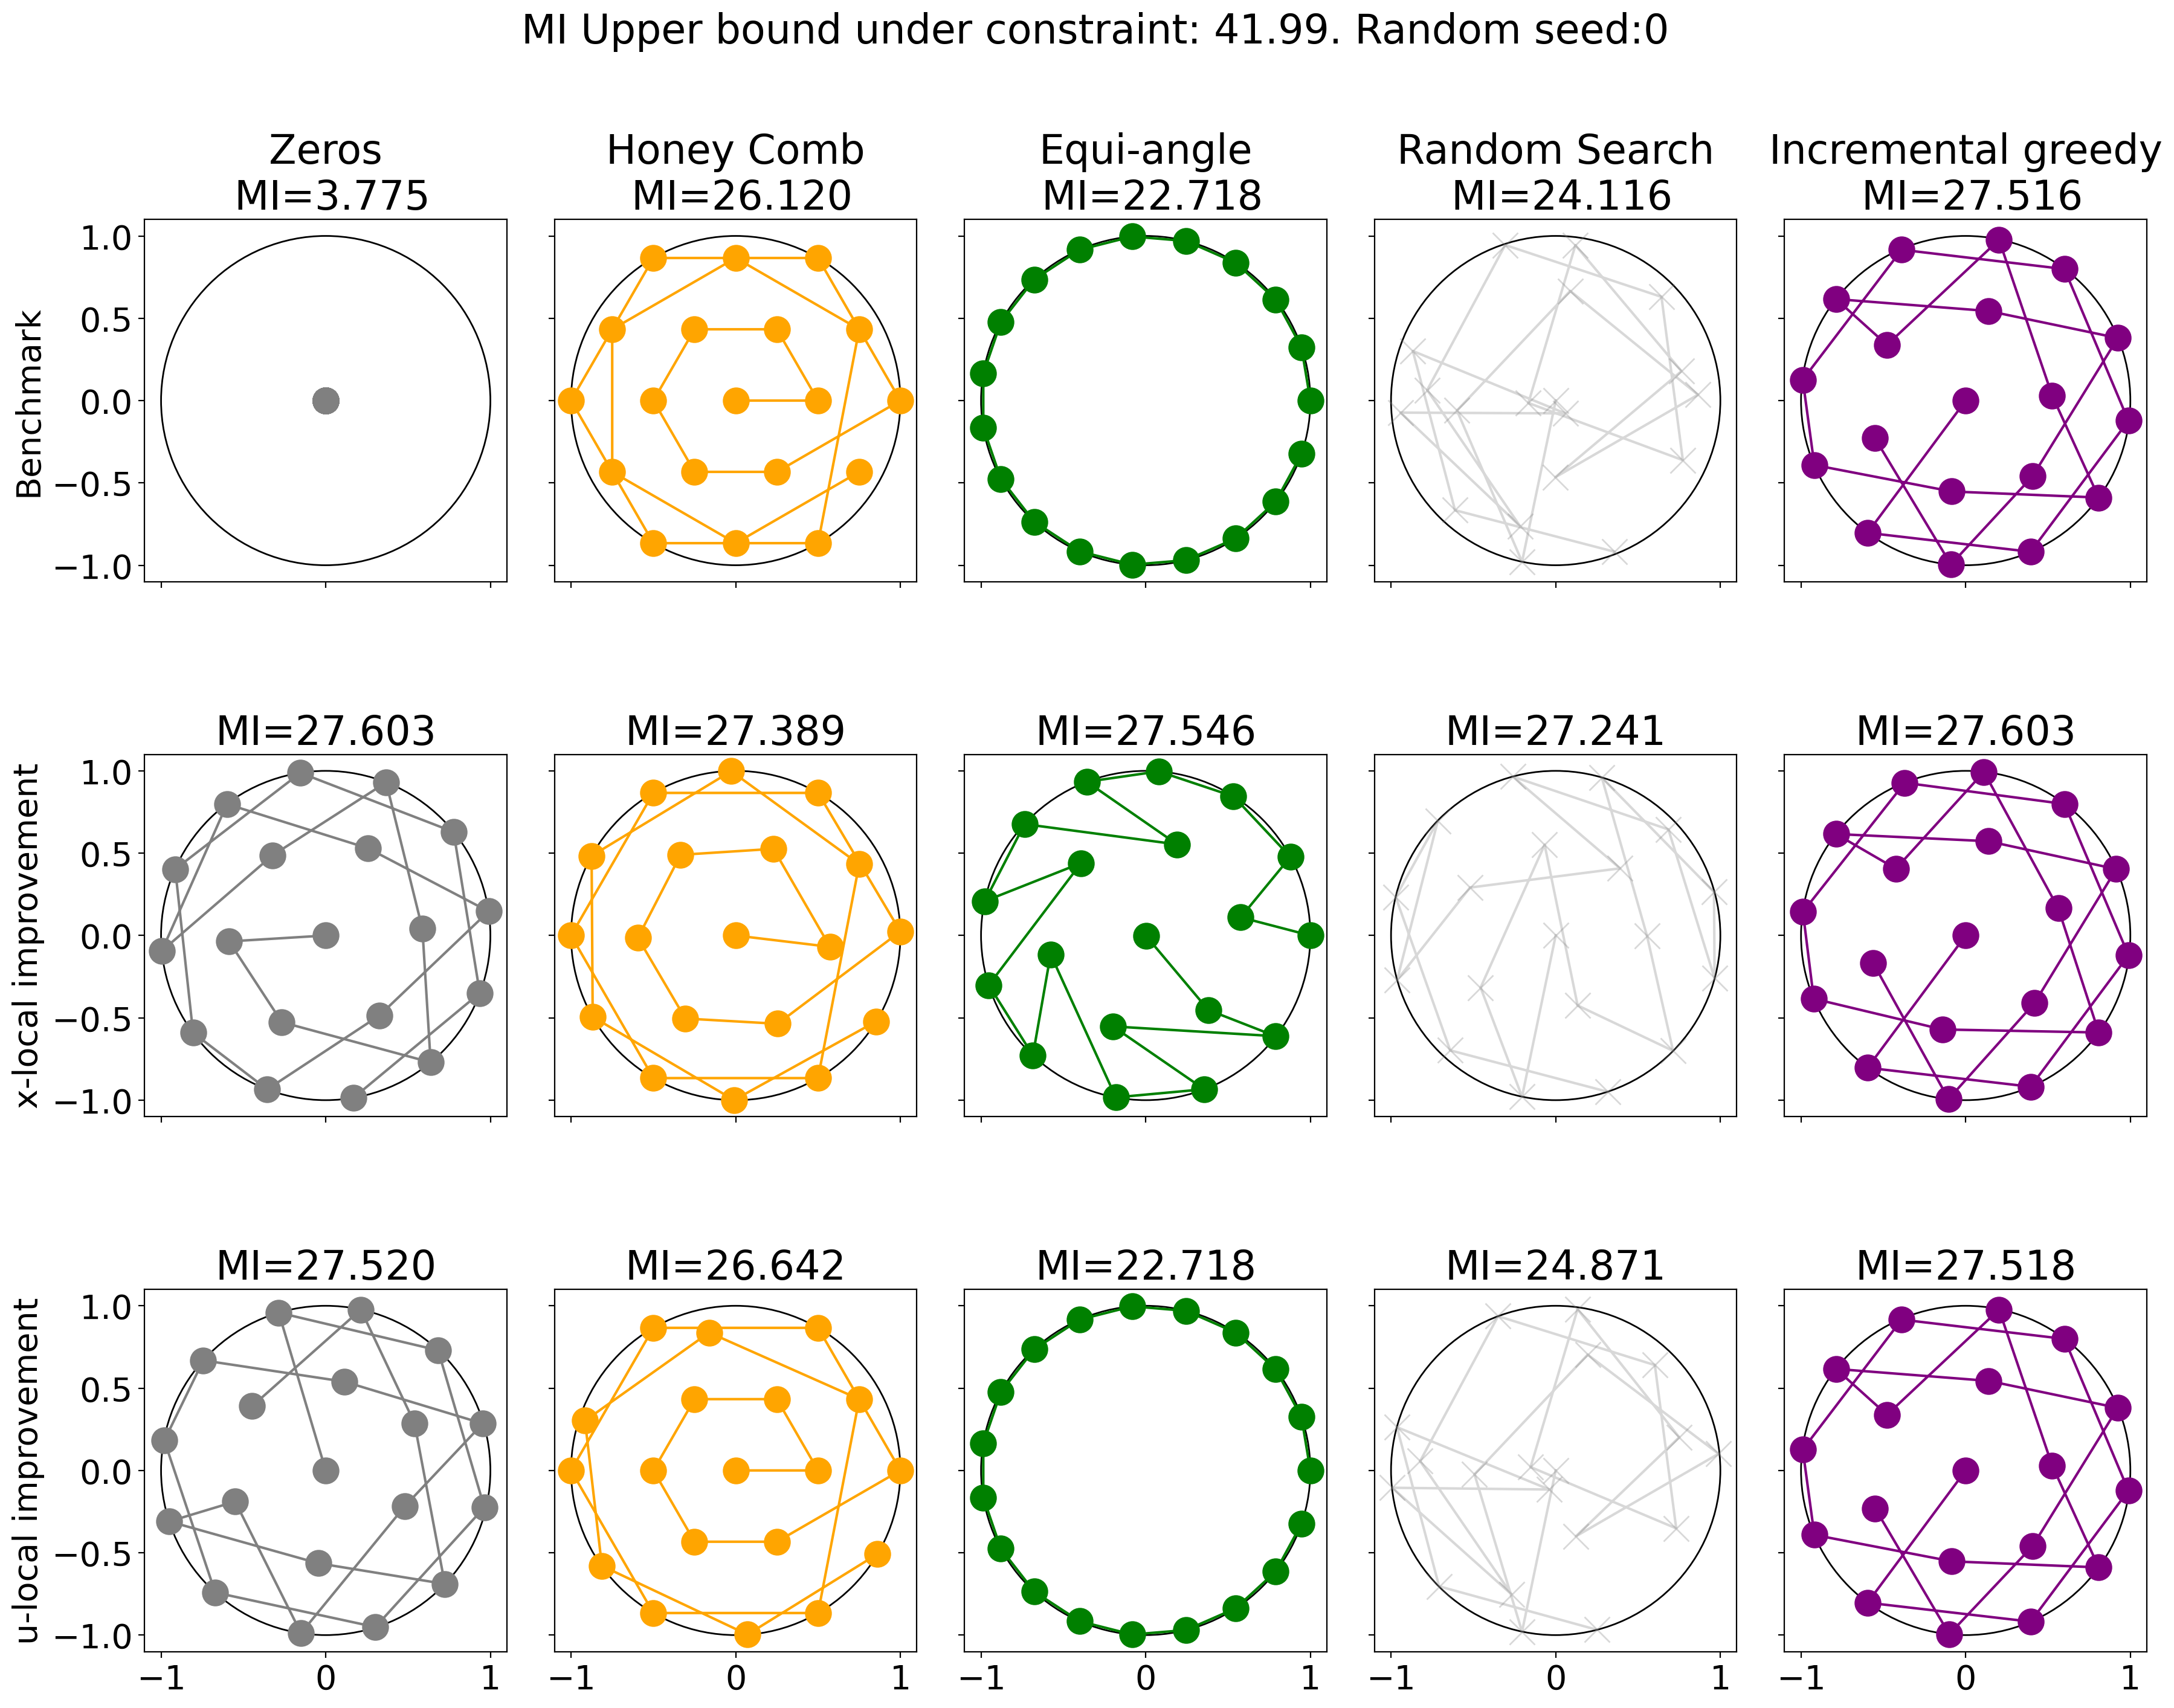

In [21]:
plt.rc('font',size=20)
fig,axes = plt.subplots(3,5,dpi=200,figsize=(18,15),sharey=True,sharex=True)

axes = axes.flatten()

for m,(key,val) in enumerate(benchmarks.items()):
    ax = axes[m]
 
    ax.plot(val[0][:,0],val[0][:,1],marker = val[3],markersize = 15,\
             alpha = val[2],
            color = val[1],)
    
    if m==0:
        ax.set_ylabel('Benchmark')
        
    ax.set_aspect('equal')

    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("{}\n MI={:.3f}".format(key,x_objective(val[0])))
    
    ax = axes[m+len(benchmarks)]
    
    # x_improvement
    ax.plot(x_improves[key][:,0],x_improves[key][:,1],marker = val[3],markersize = 15,\
         alpha = val[2],
        color = val[1],)
    
    if m==0:
        ax.set_ylabel('x-local improvement')

    
    ax.set_aspect('equal')

    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("MI={:.3f}".format(x_objective(x_improves[key])))
    
    
    # u_improvement
    ax = axes[m+2*len(benchmarks)]
    
    ax.plot(u_improves[key][:,0],u_improves[key][:,1],marker = val[3],markersize = 15,\
         alpha = val[2],
        color = val[1],)
    
    
    if m==0:
        ax.set_ylabel('u-local improvement')

    
    ax.set_aspect('equal')
    
    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("MI={:.3f}".format(x_objective(u_improves[key])))
 

    

# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.suptitle('MI Upper bound under constraint: {:.2f}. Random seed:{}'.format(upper_bound,seed))

plt.tight_layout()
plt.show()